In [3]:
import pandas as pd
from models.Hermen.model_BE2 import model_BE2, FDTi_model
import numpy as np

FBS = pd.read_csv('models/Hermen/data/FBS.csv')
QC = pd.read_csv('models/Hermen/data/QC.csv').drop(columns=['FBS_item']).rename(columns={'FBS_item': 'Item'})
RL = pd.read_csv('models/Hermen/data/RL.csv').dropna(subset=['GGI_code'])

QC = QC.groupby(['Item', 'GGI_code', 'Year', 'Area']).mean().reset_index()

In [4]:
RL[RL.GGI_code == 'IL_t_minus_1'].set_index('Area').loc['Burkina Faso']

Item        Land with temporary fallow
Element                           Area
Year                              2002
Unit                           1000 ha
Value                              536
GGI_code                  IL_t_minus_1
Name: Burkina Faso, dtype: object

In [5]:
# Aux functions, to improve. The idea is to run the model on the full database at once rather than spliiting all the stuff. Perharps using dataframe around
def pivot(df):
    return df.pivot(index=['Item'], columns='GGI_code', values='Value')


def select_country_year(df, country, year):
    return df[(df.Area==country) & (df.Year == year)].reset_index(drop=True)


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

def FBS_QC_RL_to_X(FBS, QC, RL):
    
    
    X = {}
    
    FBS_dict = df_to_dict(pivot(FBS))
    QC_dict = df_to_dict(pivot(QC))
    RL_dict = dict(zip(RL.GGI_code, RL.Value))
    
    for dictionnary in [FBS_dict, QC_dict, RL_dict]:
        X.update(dictionnary)
        
    crop_group = FBS.dropna()[FBS.dropna()['group'] == 'crop'].Item.unique()
    animal_group = FBS.dropna()[FBS.dropna()['group'] == 'animal'].Item.unique()

        
    # Stuff to clean up !!!
    X['P'] =X['P'].loc['Population']
    
    X['crop_group'] = crop_group
    X['animal_group'] = animal_group

    X['FMi'] = X['FDi'].loc[crop_group] / X['FDi'].sum()
    X['TCLD_baseline'] = X['TCLDi'].sum()
    
    X['FCRi'] = pd.Series([25, 6.4, 3.003, 2.3, 0.7, 15], index=['Bovine Meat', 'Pigmeat', 'Poultry Meat', 'Eggs', 'Milk - Excluding Butter', 'Meat, Other'])

    return X

def prepare_data_country_year(country, year, FBS=FBS, QC=QC, RL=RL):
    

    FBS_country_year = select_country_year(FBS, country, year)
    QC_country_year = select_country_year(QC, country, year)
    RL_country_year = select_country_year(RL, country, year)
    
    return FBS_QC_RL_to_X(FBS_country_year, QC_country_year, RL_country_year)

In [10]:
year = 2017
country = 'Germany'

X = prepare_data_country_year(country, year)


X['FWPPi'] = 1
X['FWCRi'] = 0
X['CRfd'] = 1
X['CD_corr'] = 1
X['R_rate'] = 0

X['FDi_baseline'] = X['FDi']
res = FDTi_model.run(X)

In [11]:
res = model_BE2.run(X)
print(res['BE2'])

32.684546469359134


In [12]:
res['FDTi'].loc['Bovine Meat']

0.03714782926829269

In [50]:
%timeit res = model_BE2.run(X)


15.7 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
res['FDTi'].loc['Vegetables, Other']

113.84733929078779

In [49]:
res['FL_t']

2057.27

In [48]:
res['chCL']

-34.0488711217933

In [75]:
res['FDTi_animal'].dropna()

Item
Meat                       109.984106
Bovine Meat                  0.029831
Mutton & Goat Meat           0.001362
Pigmeat                     20.843850
Poultry Meat               114.569834
Meat, Other                 23.982486
Animal fats                 65.072125
Butter, Ghee                 0.505303
Cream                        0.077732
Fats, Animals, Raw           6.760316
Eggs                        14.668495
Milk - Excluding Butter    339.822798
Fish, Seafood                3.343917
Freshwater Fish              0.039672
Demersal Fish                0.000000
Pelagic Fish                 0.000000
Marine Fish, Other           0.000000
Infant food                  0.000000
dtype: float64

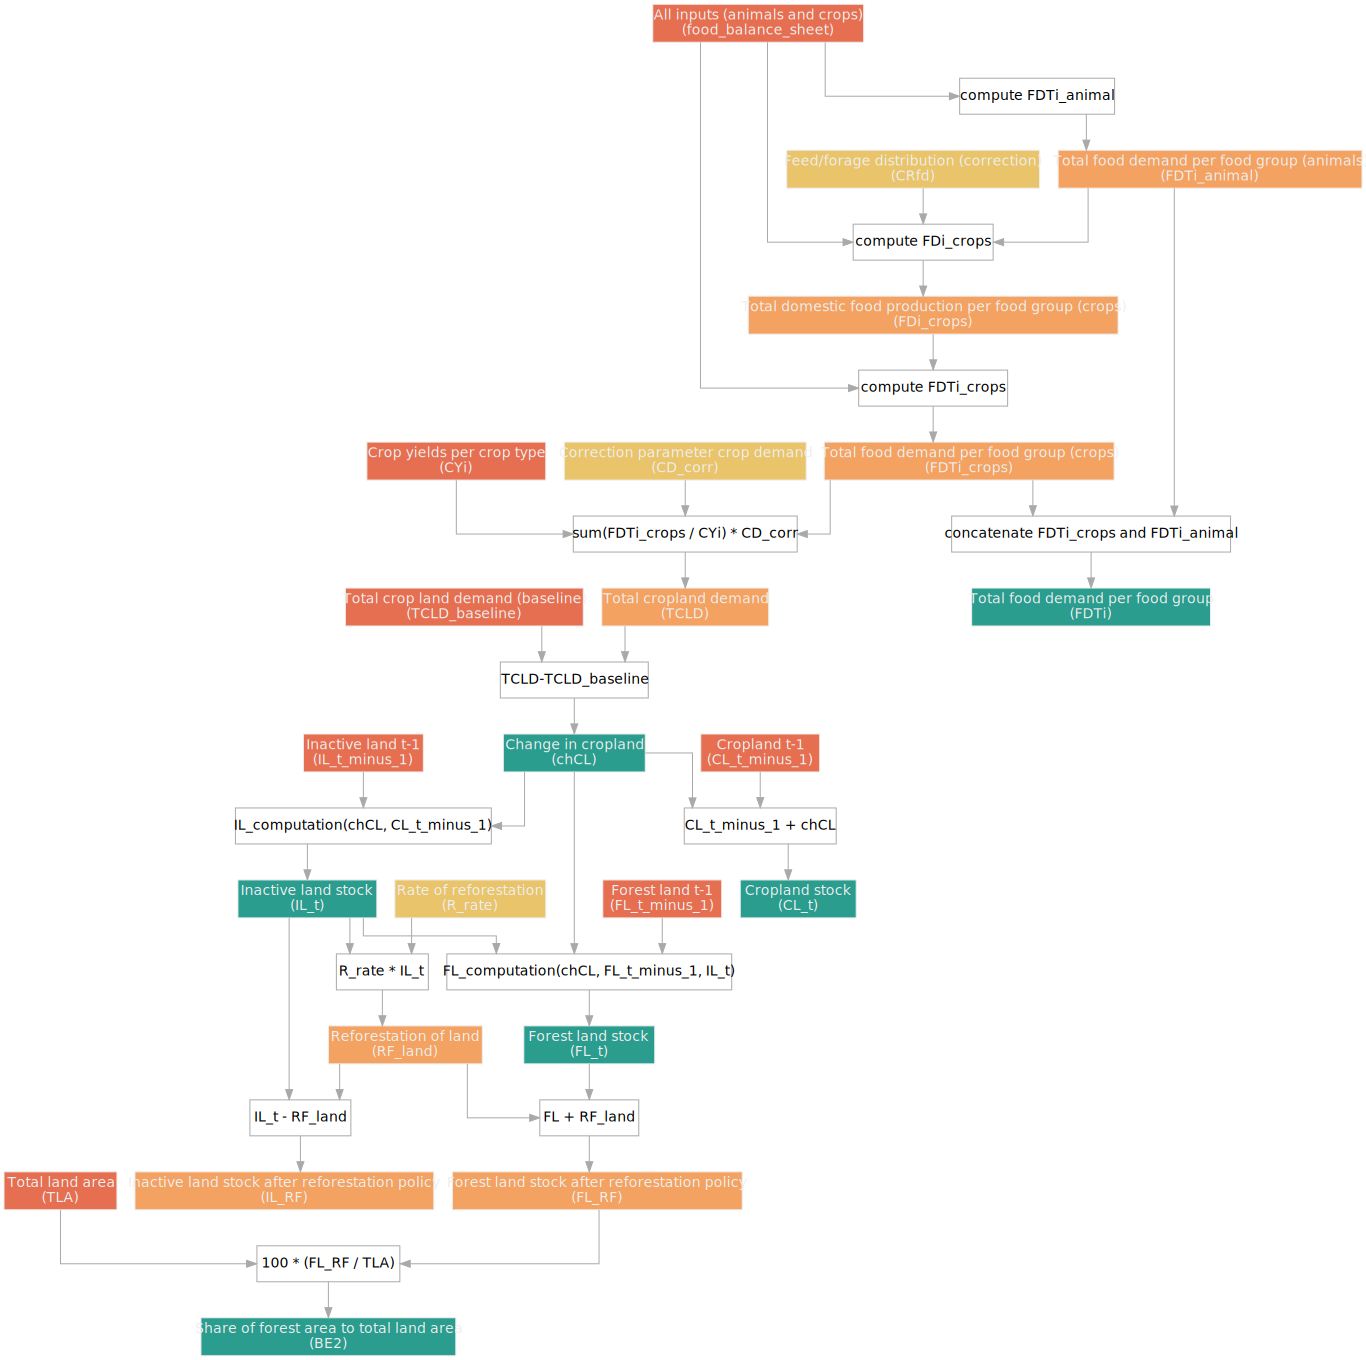

In [64]:
model_BE2.draw()

In [85]:
res['TCLD']

7043213.884530529

In [87]:
res['FDTi'].dropna().loc['Wheat and products']

-442.11323625544554

In [7]:
%timeit res = model_BE2.run(X)

14.6 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
def get_result_for_country_year(country, year):
    X = prepare_data_country_year(country, year)
    X['FWPPi'] = 0
    X['FWCRi'] = 0
    X['CRfd'] = 2
    X['CD_corr'] = 3
    X['R_rate'] = 0
    return model_BE2.run(X)

In [23]:
results = {}
year = 2016
for country in FBS.Area.unique():
    print(country,end=': ')
    try:
        results[country]  = get_result_for_country_year(country, year)
        print('done')
    except Exception as e:
        print(e)
        results[country] = np.nan

Afghanistan: done
Albania: done
Algeria: done
Angola: 'IL_t_minus_1'
Antigua and Barbuda: 'IL_t_minus_1'
Argentina: done
Armenia: done
Australia: 'IL_t_minus_1'
Austria: done
Azerbaijan: done
Bahamas: 'IL_t_minus_1'
Bangladesh: done
Barbados: 'IL_t_minus_1'
Belarus: 'IL_t_minus_1'
Belgium: done
Belgium-Luxembourg: 'P'
Belize: 'IL_t_minus_1'
Benin: 'IL_t_minus_1'
Bolivia (Plurinational State of): done
Bosnia and Herzegovina: done
Botswana: done
Brazil: 'IL_t_minus_1'
Bulgaria: done
Burkina Faso: 'IL_t_minus_1'
Cabo Verde: 'IL_t_minus_1'
Cambodia: 'IL_t_minus_1'
Cameroon: 'IL_t_minus_1'
Canada: done
Central African Republic: 'IL_t_minus_1'
Chad: 'IL_t_minus_1'
Chile: 'IL_t_minus_1'
China, Hong Kong SAR: 'IL_t_minus_1'
China, Macao SAR: 'IL_t_minus_1'
China, mainland: 'IL_t_minus_1'
China, Taiwan Province of: 'IL_t_minus_1'
Colombia: done
Comoros: 'P'
Congo: 'IL_t_minus_1'
Costa Rica: done
Côte d'Ivoire: 'IL_t_minus_1'
Croatia: done
Cuba: done
Cyprus: done
Czechia: done
Czechoslovakia: 'P

In [16]:
results['Slovakia']['BE2']

40.00353577371048